# Section III:  Stock selection for trading with reinforemcent learning

The following section summarizes empirical results of investigations of the algorithms A2C and Deep Q applied to a real stock trading problem in order to answer the questions what drives the results and how can the algorithms be adjusted. The results were deriven whether of a for loop with 10 runs and 5 training runs each or they are derived upon a typical run.

The write up is arranged in "Use Cases" with exemplary "Show Cases" and is structured as follows. The first section compromises the findings in so called "Base Case" which show how sensitive the algorithms are against the (hyper)parameter and variable setting. While the "Special Cases" show how the agent performs under stress testing, such as increased volatility or different distributions of the training and the test data set.

In [7]:
!pip install ta

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28718 sha256=98d51cbd114c7ceb40a21d0b9ea614ffc2fe4a364c54125568f78caee28853a4
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


### Base Cases

An overview of the different base cases can be found in the following.

Show Case | Type of Algorithm | Variables (short) | Companys | Epsilon | Epsilon Decay | Hidden Layers | Neurons$^1$ | start - end periode | training episodes$^2$
--- |      ---           | ---               | --- | --- | --- | --- | --- | --- | ---
1   | Deep Q             | adjClose, volume, dcf, ratings                  |Hess Corporation, TransDigm Group | 0.3 | 0.99 | 2 | 20/10 | 2010-01-01 - 2019-01-01 | 5
1.1   | Deep Q | adjClose, volume, dcf, ratings | Hess Corporation, TransDigm Group | 0.5 | 0.99 | 2 | 20/10 | 2010-01-01 - 2019-01-01 | 5
1.2   | Deep Q | adjClose, volume, dcf, ratings | Hess Corporation, TransDigm Group | 0.5 | 0.6 | 2 | 20/10 | 2010-01-01 - 2019-01-01 | 5
2     | A2C | adjClose, volume, dcf, ratings, volatility_atr, volatility_ui | NVIDIA, Celgene, ResMed, Macy´s   | n.a. | n.a. | 2 | 20/10  | 2011-01-01 - 2017-01-01 | 5
2.1     | A2C | adjClose, volume, dcf, ratings, momentum_rsi, trend_macd | NVIDIA, Celgene, ResMed, Macy´s   | n.a. | n.a. | 2 | 20/10  | 2011-01-01 - 2017-01-01 | 5
3 | A2C | adjClose, volume, dcf, ratings  |  Linde, Oracle, Philip Morris, Delta Air Lines | n.a. | n.a. | 2 | 20/10 | 2009-01-01 - 2019-01-01  | 5 |
3.1 | A2C | adjClose, volume, dcf, ratings | Linde, Oracle, Philip Morris, Delta Air Lines  | n.a. | n.a. | 3 | 25/15/15 | 2009-01-01 - 2019-01-01 | 5 | 
3.2 | Deep Q| adjClose, volume, dcf, ratings |  Linde, Oracle, Philip Morris, Delta Air Lines | 0.3 | 0.99 | 2 | 20/10 | 2009-01-01 - 2019-01-01 | 5 | 
3.3 | Deep Q| adjClose, volume, dcf, ratings|  Linde, Oracle, Philip Morris, Delta Air Lines | 0.3 | 0.99 | 2 | 25/15/15 | 2009-01-01 - 2019-01-01 | 5 | 
4 | A2C | adjClose, volume, dcf|  Morgan Stanley, Citi Group, Bank of America | n.a  | n. a. | 2 | 20/10 | 2004-06-01 - 2010-01-01 | 5 | 



Table 1

$^1$ The arrangement of the number of neurons reflect the sequence of the implemented layers. E.g. a neural network with 2 layers and 20/10 neurons has 20 neurons in the first and 10 neurons in the second layer.

$^2$ While the training episodes were diversified from 3 to 8, the Show Cases all reflect results that used 5 training runs each in order to be able to see the direct impact of the adjustments made in each case.


### Global implementation

For the sake of clarity  general valid classes, such as the environment, are implemented global in the following code.

More over, some functions are computed in order to better analyze the results within the Show Cases.


In [8]:
#@title
#Global Intializations such as the multi Stock Environment

import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
import itertools
import random
import seaborn as sns
from ta import add_all_ta_features

import tensorflow as tf
from collections import deque

class multiStockEnvironment():
    
    def __init__(self, data, tickers, state_variables, initial_investment, state_memory, use_scaling):

        # the data we want to use
        self.data = data
        # tickers for the stocks which are in the data
        self.tickers = tickers
        # the variables we want to use for state information
        self.state_variables = state_variables

        # a list of all possible actions
        self.action_list = list(map(list, itertools.product([0,1,2], repeat = len(self.tickers))))

        # money we give the agent in the beginning
        self.initial_investment = initial_investment
        # cash which is owned by the agent during an episode
        self.cash = None
        # the number of stocks an agent is holding of each stock
        self.n_stocks = None
        # the current time step
        self.current_step = None
        
        # in the beginning the scaler is not fitted so we set it to false
        self.scaler_fitted = False
        # if we want to get scaled observations from the _get_obs()-method
        self.use_scaling = use_scaling
        
        # if we have no state memory, we collect observations of states by random playing, see the initial_play method below
        if len(state_memory) == 0:
            self.initial_play()
        else:
            # if we already have a state memory, we can use it
            self.state_memory = state_memory
            self.scaler_fitted = True


    # a function to set everything to start when beginning to play an episode
    def reset(self):
        # set the current time step to zero
        self.current_step = 0
        # initialize a list for the number of stock information
        self.n_stocks = [0] * len(self.tickers)
        # in the beginning we hold as much cash as we got for an initial investment
        self.cash = self.initial_investment
        self.stock_memory = []
        
        return self._get_obs()
    
    # a function to get the current state variables, the information how much cash the agent currently holds and the number of stocks 
    def _get_obs(self):
        # concatenate the information of state, cash and number of stocks
        curr_obs = np.concatenate([self.data[self.state_variables].iloc[self.current_step, :].values, np.array([self.cash]), np.array(self.n_stocks)])

        # as long as we did not experience enough observations for scaling the state information, we remember the observations as examples
        if not(self.scaler_fitted):
            self.state_memory.append(curr_obs)
        
        # if the scaler is fitted and we want to use scaled states, we standardize them
        if self.scaler_fitted and self.use_scaling:
            curr_obs = (curr_obs - np.mean(self.state_memory, axis = 0)) / np.std(self.state_memory, axis = 0)
        
        return curr_obs

    # a function to return the value of the stocks held by the agant and its cash reserves
    def _get_value(self):
        return (self.data[['adjClose_' + t for t in self.tickers]].iloc[self.current_step, :].values.dot(self.n_stocks) + self.cash)
    
    def _get_info(self):
        return self.n_stocks.copy(), self.cash
    
    # a function to execute trades corresponding to the current action by the agent
    def _trade(self, action):
        action_vec = self.action_list[action]

        # determine which stocks should be sold and bought
        sell_index = []
        buy_index = []

        for i, a in enumerate(action_vec):
            if a == 0:
                sell_index.append(i)
            if a == 2:
                buy_index.append(i)

        # if there is anything to sell, sell it to the current price and add this to your cash holdings
        if sell_index:
            # update the amount of cash available
            self.cash += self.data[['adjClose_' + self.tickers[s] for s in sell_index]].iloc[self.current_step, :].values.dot([self.n_stocks[i] for i in sell_index])

            # update the number of stocks you are holding
            for s in sell_index:
                self.n_stocks[s] = 0

        # if there are stocks to buy, split the available cash in equal fractions of money and buy as many stocks as possible for this money
        if buy_index:
            # determine the money per stock
            money_per_stock = self.cash / len(buy_index)
            # determine how many stocks can be bought
            n_buy_stocks = np.floor(money_per_stock / self.data[['adjClose_' + self.tickers[b] for b in buy_index]].iloc[self.current_step, :].values)

            # update the number of stocks in your posssession
            for i, b in enumerate(buy_index):
                self.n_stocks[b] += n_buy_stocks[i]

            # update the cash which has been used to buy the stocks
            self.cash -= n_buy_stocks.dot(self.data[['adjClose_' + self.tickers[b] for b in buy_index]].iloc[self.current_step, :].values)
        
        self.stock_memory.append(self.n_stocks)

    # a function to exececute the trade record values development and return current information
    def step(self, action):
        # get the current value
        previous_value = self._get_value()
        # go one time step forward
        self.current_step += 1
        # execute the trade
        self._trade(action)
        # derivet the new current value
        current_value = self._get_value()
        
        # calculate the reward as the change in portfolio value plus cash reserves
        reward = (current_value - previous_value) 
        
        # check if we are at the end of the episode
        if self.current_step == (len(self.data) - 1):
            done = True
        else:
            done = False
            
        # this is a placeholder with additional information we may want to add in the future
        current_n_stocks, current_cash = self._get_info()
        info = {'stocks_in_possession': current_n_stocks, 'cash_position': current_cash}
        
        return self._get_obs(), reward, done, info
        
     
    # a function to play an episode with random actions to collect state variables for scaling
    def initial_play(self):
        # initialize a memory for exemplary state observations
        self.state_memory = []
        # start the episode
        s = self.reset()
        done = False
        
        # until the episode execute random actions and go one time step forward
        while not(done):
            a = random.choice(np.arange(0, len(self.action_list)))
            s_, r, done, info = self.step(a)
                
        print(f'Played one episode with random actions to collect state and reward observations!')
        
        self.state_memory = np.array(self.state_memory)
        self.scaler_fitted = True





#### Deep Q Agent and training instance function

In [9]:
#@title
# a class definition for the Deep-Q-Agent
class DeepQAgent():
    def __init__(self, input_dim, output_dim, optimizer, gamma = 1):
        # input dimension is the number of state variables which are used for estimating q-values
        self.input_dim = input_dim
        # output dimension is the number of actions for which q-valus are estimated
        self.output_dim = output_dim
        # discounting factor
        self.gamma = gamma
        
        # a network for estimating q-values
        self.q_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (self.input_dim)),
            tf.keras.layers.Dense(20, activation = 'relu'),
            tf.keras.layers.Dense(10, activation = 'relu'),
            tf.keras.layers.Dense(self.output_dim)
        ])
        
        # a copy of the network above which is used for estimating action values of the next-step-action pair
        # this network is only updated after a certain number of steps
        self.target_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (self.input_dim)),
            tf.keras.layers.Dense(20, activation = 'relu'),
            tf.keras.layers.Dense(10, activation = 'relu'),
            tf.keras.layers.Dense(self.output_dim)
        ])
        
        # the tensorflow optimizer we want to use
        self.optimizer = optimizer
        
        if case_number == '1':
          self.epsilon = 0.30
          self.epsilon_decay = 0.999

        elif case_number == '1.1':
          self.epsilon = 0.5
          self.epsilon_decay = 0.999

        elif case_number == "1.2":
          self.epsilon  = 0.5
          self.epsilon_decay = 0.6
        
          
        # minimum value for epsilon
        self.epsilon_min = 0.01
        
        # a dynamic list for memorizing loss values - divergence between target and predictions
        self.loss_memory = deque(maxlen = len(data_train))
        
        # copy the parameters of the q-network to the target network in the beginning
        self.update_target_network()
        # set target step to zero, it will be increased by one after each training step and parameters are copied after one hundred target steps
        self.target_step = 0
        
    # a function to copy parameters of the q-network to the target network
    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())
        
    # select an action by epsilon-greedy-strategy
    def action(self, state):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice(np.arange(0, self.output_dim))
        else:
            return np.argmax(self.q_network(state.reshape(1, -1)).numpy()[0])
    
    # parameter update by target and prediction divergence
    def train(self, state, action, reward, next_state, done):
        # derive the target value
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.target_network(next_state.reshape(1, -1)).numpy()[0])
            
        # determine the gradient of the q-network with respect to the divergence between the target and the predicted q-value
        with tf.GradientTape() as tape:
            tape.watch(self.q_network.trainable_variables)
            # make prediction with the q-network
            predict = self.q_network(state.reshape(1, -1))
            # generate a target vector with all values equal to the prediction
            full_target = predict.numpy()
            # replace the real target value for the action which has been chosen
            full_target[0, action] = target
            full_target = tf.convert_to_tensor(full_target)

            # determine the loss - squared difference between target and prediction
            loss = tf.square(full_target - predict)
    
        # memorize the current loss value
        self.loss_memory.append(loss.numpy()[0])
    
        # get the gradients and use them for a gradient update step
        self.optimizer.apply_gradients(zip(tape.gradient(loss, self.q_network.trainable_variables), self.q_network.trainable_variables))

        # reduce epsilon after each gradient update
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        # after 100 training steps renew parameters in the target network by current parameters of the q-network
        self.target_step += 1
        if self.target_step == 100:
            self.update_target_network()
            self.target_step = 0

In [10]:
#@title
from tqdm import tqdm

def trade_training_DeepQ():
    
  # the number of training episodes
  training_episodes = 5


  # collect final values at the end of each episode
  final_values = []
  # collect time series of portfolio values over time
  values_ts = []
  # collect time series of actions during each episode
  actions_ts = []
  # collect information, i.e., the number of stocks and cash over time for each episode
  infos_ts = []
  # training loss
  loss_during_training = []
  # collect the learned parameters of the networks after each training episode
  agent_weights = []
  agent_weights_target = []

  # repeat this for the number of training episodes
  for _ in tqdm(range(training_episodes)):
      # reset the environment to time step 0
      s = env_train.reset()
      done = False
      # temporary lists to collect actions chosen, values and stock information
      actions = []
      values = []
      infos = []

      # for each episode do the following
      while not(done):
          # choose an action according to epsilon-greedy-strategy
          a = agent.action(s)
          # remember the chosen action
          actions.append(a)
          # take the action, collect the reward and move to the next point in time
          s_, r, done, info = env_train.step(a)
          # memorize the number of stocks at this point in time and the cash position
          infos.append(info)
          # train the agent/update the parameters
          agent.train(s, a, r, s_, done)
          # remember the current value of stocks hold and the cash position
          values.append(env_train._get_value())
          s = s_

      # memorize everything that happened during the episode
      final_values.append(values[-1])
      actions_ts.append(actions)
      values_ts.append(values)
      infos_ts.append(infos)
      loss_during_training.append(np.mean(agent.loss_memory))
      agent_weights.append(agent.q_network.get_weights())
      agent_weights_target.append(agent.target_network.get_weights())



  # plot the summary of value development and actions over all episodes
  fig, axes = plt.subplots(1, 3, figsize = (14, 6))

  axes[0].hist(final_values)
  axes[0].set_xlabel('Final value')

  for i, acs in enumerate(actions_ts):
      axes[1].scatter(data_train.index[1:], acs, label = f'Run: {i+1}', alpha = 0.5)
  axes[1].set_xlabel('Time steps')
  axes[1].set_ylabel('Actions')
  axes[1].legend()

  for i, v in enumerate(values_ts):
      axes[2].plot(data_train.index[1:], v, label = f'Run: {i+1}')
  axes[2].set_xlabel('Time steps')
  axes[2].set_ylabel('Value')
  axes[2].legend()
  fig.autofmt_xdate(rotation = 45)
  plt.show()


  # make a barchart of all actions for each episode
  fig, axs = plt.subplots(1, len(actions_ts), figsize = (24,6))

  for i in range(len(actions_ts)):
      unique, counts = np.unique(np.array(actions_ts[i]), return_counts=True)
      axs[i].bar(unique, counts)
      axs[i].set_title(f'Actions chosen during training run: {i+1}')
  fig.autofmt_xdate(rotation = 45)
      
  # show which stocks are hold at each point in time for every episode
  fig, axs = plt.subplots(1, len(actions_ts), figsize = (24,6))

  for i in range(len(infos_ts)):
      for n, t in enumerate(tickers):
          axs[i].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_ts[i]])[:, n], label = t)
      
      axs[i].legend()
      
  fig.autofmt_xdate(rotation = 45)
  plt.show()

  # show the most frequent action

  favourite_action = find_most_frequent_action(actions)
  print(f'The most frequent action is in the {training_size}th is {favourite_action}, while 0 stands for sell, 1 for hold and 2 for buy.')

#### A2C Agent and training instance function

In [11]:
#@title
# a class for the actor-critic agent
class A2C():
    def __init__(self, input_dim, output_dim, policy_optimizer, value_optimizer, action_list):
        # input dimension = number of variables used for police and state value estimation
        self.input_dim = input_dim
        # output dimension for actions
        self.output_dim = output_dim
        # an optimizer used for the policy network
        self.policy_optimizer = policy_optimizer
        # an optimizer used for the state value network
        self.value_optimizer = value_optimizer
        
        # a neural network for the policy
        self.policy_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = self.input_dim),
            tf.keras.layers.Dense(20, activation = 'relu'),
            tf.keras.layers.Dense(10, activation = 'relu'),
            tf.keras.layers.Dense(self.output_dim, activation = 'softmax')
        ])
        
        # a neural network for state value estimation
        self.value_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = self.input_dim),
            tf.keras.layers.Dense(20, activation = 'relu'),
            tf.keras.layers.Dense(10, activation = 'relu'),
            tf.keras.layers.Dense(1)
        ])
        
        # the list with all possible actions
        self.action_list = action_list
        
    #  a method for choosing an action according to current action probabilities
    def action(self, state):
        action = random.choices(np.arange(len(env_train.action_list)), weights = self.policy_network(state.reshape(1, -1))[0])[0]
        return action
    
    # a function to derive necessary gradients and update parameters of the policy and the value network
    def train(self, state, action, reward, next_state, done):
        
        # first get the gradients of the policy function for the chosen action
        with tf.GradientTape() as policy_tape:
            # the one-hot "trick" is used to focus on the chosen action in the step
            one_hot = np.zeros(shape = (len(self.action_list), 1))
            one_hot[action, 0] = 1.
            one_hot = tf.convert_to_tensor(one_hot, dtype = tf.float32)

            # this is the probability for choosing the current action according to the policy network function
            prob_a = tf.math.log(tf.linalg.matmul(self.policy_network(state.reshape(1, -1)), one_hot))

        # gradient of the log-probability from above with respect to the parameters of the policy network
        policy_grads = policy_tape.gradient(prob_a, self.policy_network.trainable_variables)
        
        # get the state value
        with tf.GradientTape() as value_tape:
            value_s = self.value_network(state.reshape(1, -1))

        # gradient of the state value with respect to the parameters of the state value network
        value_grads = value_tape.gradient(value_s, self.value_network.trainable_variables)
        
        # determine the return with TD(0) method
        if done:
            target = reward
        else:
            target = reward + self.value_network(next_state.reshape(1, -1)).numpy()[0][0]
                
        # how far away is the prediction of the state value from the (semi-)realized TD(0) return
        error = target - value_s.numpy()[0][0]
        
        # multiply each gradient value with the TD(0)-error
        policy_grads = [pg * error for pg in policy_grads] 
        value_grads = [vg * error for vg in value_grads] 
        
        # update all parameters according to the gradient information
        self.value_optimizer.apply_gradients(zip(value_grads, self.value_network.trainable_variables))
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_network.trainable_variables))

In [12]:
#@title

def trade_trainingA2C():
  from tqdm import tqdm

  # the number of training episodes
  training_episodes = 5

  # collect final values at the end of each episode
  final_values = []
  # collect time series of portfolio values over time
  values_ts = []
  # collect time series of actions during each episode
  actions_ts = []
  # collect information, i.e., the number of stocks and cash over time for each episode
  infos_ts = []
  # training loss
  loss_during_training = []
  # collect the learned parameters of the networks after each training episode
  agent_weights_policy = []
  agent_weights_value = []

  # repeat this for the number of training episodes
  for _ in tqdm(range(training_episodes)):
      # reset the environment to time step 0
      s = env_train.reset()
      done = False
      # temporary lists to collect actions chosen, values and stock information
      actions = []
      values = []
      infos = []

      # for each episode do the following
      while not(done):
          # choose an action according to epsilon-greedy-strategy
          a = agent.action(s)
          # remember the chosen action
          actions.append(a)
          # take the action, collect the reward and move to the next point in time
          s_, r, done, info = env_train.step(a)
          # memorize the number of stocks at this point in time and the cash position
          infos.append(info)
          # train the agent/update the parameters
          agent.train(s, a, r, s_, done)
          # remember the current value of stocks hold and the cash position
          values.append(env_train._get_value())
          s = s_

      # memorize everything that happened during the episode
      final_values.append(values[-1])
      actions_ts.append(actions)
      values_ts.append(values)
      infos_ts.append(infos)
      agent_weights_policy.append(agent.policy_network.get_weights())
      agent_weights_value.append(agent.value_network.get_weights())

  # plot the summary of value development and actions over all episodes
  fig, axes = plt.subplots(1, 3, figsize = (14, 6))

  axes[0].hist(final_values)
  axes[0].set_xlabel('Final value')

  for i, acs in enumerate(actions_ts):
      axes[1].scatter(data_train.index[1:], acs, label = f'Run: {i+1}', alpha = 0.5)
  axes[1].set_xlabel('Time steps')
  axes[1].set_ylabel('Actions')
  axes[1].legend()

  for i, v in enumerate(values_ts):
      axes[2].plot(data_train.index[1:], v, label = f'Run: {i+1}')
  axes[2].set_xlabel('Time steps')
  axes[2].set_ylabel('Value')
  axes[2].legend()
  fig.autofmt_xdate(rotation = 45)
  plt.show()


  # make a barchart of all actions for each episode
  fig, axs = plt.subplots(1, len(actions_ts), figsize = (24,6))

  for i in range(len(actions_ts)):
      unique, counts = np.unique(np.array(actions_ts[i]), return_counts=True)
      axs[i].bar(unique, counts)
      axs[i].set_title(f'Actions chosen during training run: {i+1}')
  fig.autofmt_xdate(rotation = 45)
      
  # show which stocks are hold at each point in time for every episode
  fig, axs = plt.subplots(1, len(actions_ts), figsize = (24,6))

  for i in range(len(infos_ts)):
      for n, t in enumerate(tickers):
          axs[i].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_ts[i]])[:, n], label = t)
      
      axs[i].legend()
      
  fig.autofmt_xdate(rotation = 45)
  plt.show()

  favourite_action = find_most_frequent_action(actions)
  print(f'The most frequent action is in the {training_size}th is {favourite_action}, while 0 stands for sell, 1 for hold and 2 for buy.')

The function $casedata-collect$ performs different data collection processes received by financialmodelingprep.com. The input of the function is the case number according to Table 1. After the data is downloaded it is processed and merged according within each individual case. 

In [13]:
#@title
def casedata_collect(case_number):
  
  if case_number == "1":
    tickers = ["HES","TDG"]
    start_date = '2010-01-01'
    end_date = '2019-01-01'

  elif case_number == "1.1":
    tickers = ["HES","TDG"]
    start_date = '2010-01-01'
    end_date = '2019-01-01'

  elif case_number == "1.2":
    tickers = ["HES","TDG"]
    start_date = '2010-01-01'
    end_date = '2019-01-01'

  elif case_number == "2":
    tickers = ["NVDA","CELG","RMD","M"]
    start_date = '2011-01-01'
    end_date = '2017-01-01'

  elif case_number == "2.1":
    tickers = ["NVDA","CELG","RMD","M"]
    start_date = '2011-01-01'
    end_date = '2017-01-01'

  elif case_number == "3":
    tickers = ["LIN","ORCL","PM","DAL"]
    start_date = '2009-01-01'
    end_date = '2019-01-01'

  elif case_number == "4":
    tickers = ["MS","C","BAC"]
    start_date = '2004-06-01'
    end_date = '2010-01-01'

  else:
    print("Show Case is not defined")

  # dictionary to collect data of each stock
  all_dfs = {}

  # financialprepmodeling api, you should be able to use this api-key and it should provide you with access to all data on financial modeling prep, if not please let me know
  api_key = '886a9473ba9b2905fd5528eebce1f10b'

  for t in tickers:

      # keys for the first two requests
      keys = {'apikey': api_key}

      # collect discounted cash flow data
      url = 'https://financialmodelingprep.com/api/v3/historical-daily-discounted-cash-flow/' + t
      r = requests.get(url, params = keys)

      if r.status_code == requests.codes.ok:
          data_dcf = r.json()
      else:
          print('Stock market data for {} could not be downloaded!'.format(t))

      df_dcf = pd.DataFrame(data_dcf)

      # collect analyst rating data
      url = 'https://financialmodelingprep.com/api/v3/historical-rating/' + t
      r = requests.get(url, params = keys)

      if r.status_code == requests.codes.ok:
          data_rating = r.json()
      else:
          print('Stock market data for {} could not be downloaded!'.format(t))

      df_rating = pd.DataFrame(data_rating)

      # keys for stock price collection
      keys = {'apikey': api_key, 'from': start_date, 'to': end_date}

      url = 'https://financialmodelingprep.com/api/v3/historical-price-full/' + t
      r = requests.get(url, params = keys)

      if r.status_code == requests.codes.ok:
          data_stock_prices = r.json()
      else:
          print('Stock market data for {} could not be downloaded!'.format(t))

      df_stock_prices = pd.DataFrame(data_stock_prices['historical'])

      # we have three data frames, now we merge them by setting the date as index and merge it along this information
      df_dcf.set_index('date', inplace=True)
      df_dcf.drop(['symbol'], axis = 1, inplace = True)
      df_dcf.index = [datetime.strptime(d, '%Y-%m-%d') for d in df_dcf.index] 
      df_dcf = df_dcf.sort_index()

      df_rating.set_index('date', inplace = True)
      df_rating = df_rating[df_rating.columns[ df_rating.dtypes == 'int64' ]]
      df_rating.index = [datetime.strptime(d, '%Y-%m-%d') for d in df_rating.index] 

      df_stock_prices.set_index('date', inplace = True)
      df_stock_prices.index = [datetime.strptime(d, '%Y-%m-%d') for d in df_stock_prices.index] 
      df_stock_prices = df_stock_prices.sort_index()

      # calculate technical indicators such that we can optionally use them later
      df_stock_prices = add_all_ta_features(df_stock_prices, open = "open", high = "high", low = "low", close = "adjClose", volume = "volume", fillna=False)

      # check if too many observations are missing / can not be determined of a techncial indicator, if yes delete the indicator
      too_much_missing = df_stock_prices.columns[df_stock_prices.isnull().sum(axis = 0) > 50]
      df_stock_prices = df_stock_prices.drop(too_much_missing, axis = 1)

      # also delete the first rows with NaN values
      df_stock_prices = df_stock_prices[df_stock_prices.isnull().sum(axis = 1) == 0]

      # remove the last row, because we can not determine the target variable for it
      df_stock_prices = df_stock_prices.iloc[:-1,:]
      
      df_company = df_stock_prices.merge(df_dcf, how = 'inner', left_index = True, right_index = True).merge(df_rating, how = 'inner', left_index = True, right_index = True)

      all_dfs[t] = df_company

      
            

  return tickers, all_dfs

For further analysis the function $find-most-frequent-action$ is implemented, which shows the action which has been done the most in the last training run or in the testing run. As input serves the action list which is collected within the for loops. The function is implemented within the training runs.

In [14]:
#@title

#In order to find the action which is performed the most frequent, for further analysis, the following function is added:
import numpy as np

def find_most_frequent_action(List):
  counter = 0
  num = List[0]

  for i in List:
    curr_frequency = List.count(i)
    if(curr_frequency > counter):
      counter = curr_frequency
      num = i
  return env_train.action_list[num]


#find_most_frequent_action()


## Base Cases
### Base Case I: Epsilon´s and epsilon decay´s impact on the Deep Q algorithm

In this Use Case the effect of different epsilon and epsilon decays on the Deep Q algorithm is summarized. While in the empirical investigation several company settings were used, the following show case is applied to one setting which consists of Hess Corporation (HES) and the TransDigm Group (TDG). 

Further the standard case involves an epsilon of 0.3 and a epsilon decay of 0.99. In other words, in the standard case the agent chooses an action with a probability of 30% randomly and acts greedy with a probability of 70%.

To be able to see the difference of the epsilon adjustments, the standard case (Case 1 in Table 1) is performed in the following:

In [ ]:
#@title

data_and_tickers = casedata_collect("1") 
case_number = "1"

tickers = data_and_tickers[0]
all_dfs = data_and_tickers[1]

try:
    del data
except:
    None

# define the variables we want to use, adjClose is necessary to calculate rewards, remaining variables can be set freely by the user
keep_vars = [
             'adjClose', 'volume', # stock information
             'dcf', # discounted cash flow
             'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore'#, # analyst ratings
             #'momentum_rsi', 'trend_macd', 'volatility_atr' # technical indicators
            ]

# loop through each data frame per stock rename columns and merge data
for t in tickers:
    df = all_dfs[t][keep_vars]
    df.columns = [col_name + '_' + t for col_name in df.columns]

    try:
        data = data.merge(df, how = 'outer', left_index = True, right_index = True, suffixes = ['', ''])
    except:
        data = df.copy()

# if there are only a few, we may just skip those rows, otherwise get other data
data = data[data.isnull().sum(axis = 1) == 0]

# we use 70% of the data for training, the remainder is used for testing purposes
training_fraction = 0.70
training_size = int(len(data) * training_fraction)
# split the data
data_train = data.iloc[:training_size, :]
data_test = data.iloc[training_size:, :]

#define the state variables
state_vars = data.drop(['adjClose_' + t for t in tickers], axis = 1).columns
# some variables do not change over time, we delete them as nothing can be learned from a variable that does not change over time
state_vars = state_vars[data_train.drop(['adjClose_' + t for t in tickers], axis = 1).std() > 0.01]
# define the environment for training data
env_train = multiStockEnvironment(data_train, tickers, state_vars, 10000, [], True)
# define the environment for test data, using the state memory from training data for scaling
env_test = multiStockEnvironment(data_test, tickers, state_vars, 10000, env_train.state_memory, True)

# define an optimizer of tensorflow
adam = tf.keras.optimizers.Adam()
# define an instance of a Deep-Q-Agent

case_number = "1"

agent = DeepQAgent(input_dim = len(env_train.state_variables) + len(tickers) + 1, output_dim = len(env_train.action_list), optimizer = adam)

#training executed via the training instance
trade_training_DeepQ()


The result is clear. In this case the agent chooses TDG within a typical run, as it is the trending stock, more and more while the epsilon is decreasing and the agent acts according increasingly to a greedy policy. Hence the agent is able to increase the initial investment of 10.000 monetary units in the testing phase. The same pattern can be observed within the test run.

Of course this example is easy for the Deep Q agent since the trend of the selected stocks goes in different directions as can be seen in the following plot. But this way it enables the analyses of the impact of the chossen epsilon and epsilon decay.


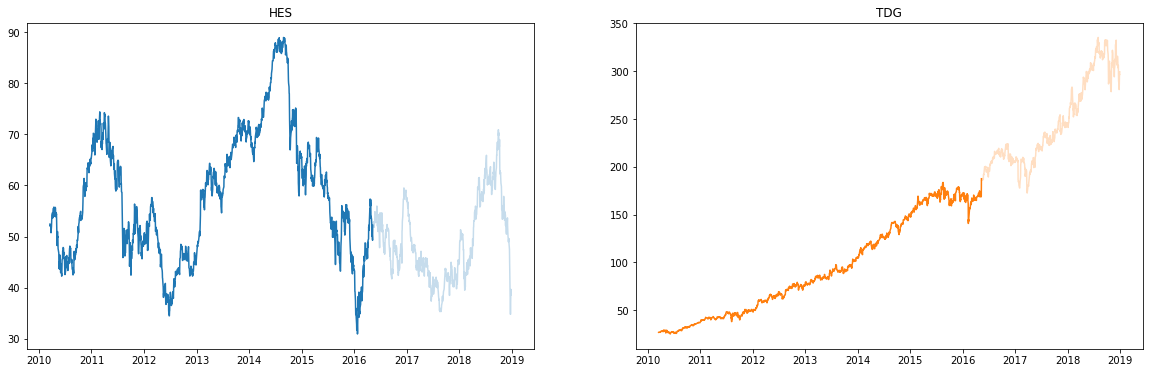

In [16]:
# let us take a look of the stock price development over the whole time span
cols = sns.color_palette(n_colors = len(tickers))
fig, axs = plt.subplots(1, len(tickers), figsize = (20, 6))

try:
    for i, t in enumerate(tickers):
        axs[i].plot(data_train['adjClose_' + t], color = cols[i], label = t)
        axs[i].plot(data_test['adjClose_' + t], color = cols[i], alpha = 0.25)
        axs[i].set_title(t)
except:
    axs.plot(data_train['adjClose_' + t], color = cols[i], label = t)
    axs.plot(data_test['adjClose_' + t], color = cols[i], alpha = 0.25)
    axs.set_title(t)

#### Impact of a changed epsilon value

In order to be able to analyze the impact of epsilon on the Deep Q Algorithm, it´s value was increased from initial 0.3 several times until it reached a value of 0.5. With a epsilon of 0.5 the agent acts 50% random and 50% greedy at the beginning. 

While the epsilon was pieceweise increased with an additional value of 0.05 it can be observed that the agent more and more diversifies his portfolio. In other words, since the agent know is able to explore at a higher rate at the beginning, it is able to also evaluate trading decisions which do not correspond to the most trending stock. 

Exemplary this can be seen in the Case 1.1 in which the epsilon was changed to a value of 0.5:

In [ ]:
#@title
data_and_tickers = casedata_collect("1.1") 

tickers = data_and_tickers[0]
all_dfs = data_and_tickers[1]

try:
    del data
except:
    None

# define the variables we want to use, adjClose is necessary to calculate rewards, remaining variables can be set freely by the user
keep_vars = [
             'adjClose', 'volume', # stock information
             'dcf', # discounted cash flow
             'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore'#, # analyst ratings
             #'momentum_rsi', 'trend_macd', 'volatility_atr' # technical indicators
            ]

# loop through each data frame per stock rename columns and merge data
for t in tickers:
    df = all_dfs[t][keep_vars]
    df.columns = [col_name + '_' + t for col_name in df.columns]

    try:
        data = data.merge(df, how = 'outer', left_index = True, right_index = True, suffixes = ['', ''])
    except:
        data = df.copy()

data.head()

#define the state variables
state_vars = data.drop(['adjClose_' + t for t in tickers], axis = 1).columns
# some variables do not change over time, we delete them as nothing can be learned from a variable that does not change over time
state_vars = state_vars[data_train.drop(['adjClose_' + t for t in tickers], axis = 1).std() > 0.01]
# define the environment for training data
env_train = multiStockEnvironment(data_train, tickers, state_vars, 10000, [], True)
# define the environment for test data, using the state memory from training data for scaling
env_test = multiStockEnvironment(data_test, tickers, state_vars, 10000, env_train.state_memory, True)

# define an optimizer of tensorflow
adam = tf.keras.optimizers.Adam()
# define an instance of a Deep-Q-Agent

case_number = "1.1"

agent = DeepQAgent(input_dim = len(env_train.state_variables) + len(tickers) + 1, output_dim = len(env_train.action_list), optimizer = adam)

trade_training_DeepQ()

The result is not surprising. Due to the increased randomness of the agent he or her does not immediately focus on one specific action, as with a lower epsilon, even though the TDG stock would be more profitable. The result lies probably in the timely distribution of the HES returns. While the epsilon is still high at the beginning, due to the high epsilon decay of 0.99, the agent gets rewarded for choosing HES as it is, after approximately 2012, highliy increasing at the beginning. However the furhter development of the HES stock should penalize the Q values which include HES preffering actions. Nevertheless the penalty is not high enough in order to make the agent to buy TDG exclusively.
Increasing the number of training periodes, e. g. from 5 to 8, does not particularly affect a typical course.

However buying HES for a time is not a problem if it is increasing but letting the trending stock TDG behind is a disadvantage anyway.

#### Impact of epsilon decay
The same company and variable setting was also used with a lower epsilon decay in Case 1.2. Since a lower epsilon decay has the consequence that the agent acts greedy faster and faster, the agent again decides for the trending TDG stock. Therefore it can be derived that setting epsilon and epsilon decay to appropriate values at the beginning is crucial. 

The importance can be seen in the testing phase. Fig 1 shows a typical test run with a epsilon decay of 0.6 and a epsilon of 0.5. In this case the agents return development is shaped by the most frequent action which is holding TDG and selling HES. Despite some negative development at the beginning the agent is able to increase the investment of 10.000 to 15950.68, which is a return of 59.51%. However, Fig. 2 shows a typical test run with the most frequent action of buying HES and holding TDG with an epsilon decay of 0.999 and a epsilon of 0.5. The agent is barely able to compensate the loss in the first years and finally crashes due to the investment decisions in HES.

Consequently, it is not only important to find the right values for epsilon and epsilon decay stand alone but rather the right combination.


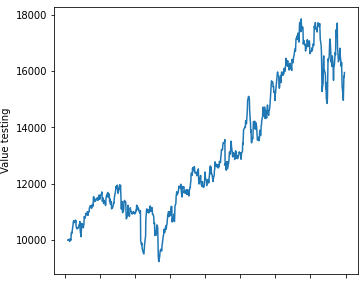

Fig. 1

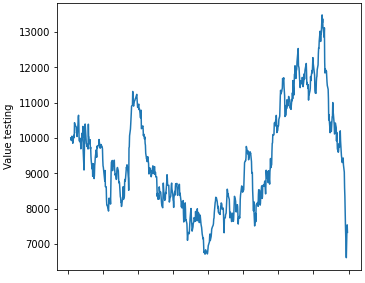

Fig 2

#### Case Conclusion

As obsereved setting epsilon and epsilon decay to the right value is critical for the result. Of course this example is overstated and provokes the analysed results but it still shows the importance of finding the right values. The literature and communities advise to use cross validation (CV) in order to find the right values. Therefore applying methods such as CV could improve the performance.

Besides the gained knowledge of the importance of implementing the right values, this case also shows one drawback of the Deep Q algorithm compared to the A2C. Since it is not necessary to control the A2Cs greedines as it does itself by valueing it´s decisions and using a policy gradient, which has as output probabilites (actor vs critic).

Applying the A2C-Algorithm to the same company and time settings which were used to derive the findings of Case 1 and 1.1, it can be noticed that it also has problems outperforming a random agent, but selects most of the time to focus on the trending TDG stock.

However, with increasing number of companies and regardless of the time setting, the A2C agent diversifies more if all stocks tend to increase it´s price. Instead of buying the most trending stock the A2C agent interacts more frequent with the possible actions, significantly more as the Deep Q agent, in the training phase (5th run). Therefore it may can be said, that the A2C algorithm is better for investors which wish to have a diversified portfolio. Since the trader has not to make assumptions about the right values for epsilon and epsilon decay it is possible to lower the risk of a too greedy acting agent, which may makes wrong decisions.

### Base Case II:  The effect of increased volatility on the A2C agents performance and the effect of hyperparameters and different variables on it

From the results above it was derived that the A2C algorithm is better for broughter diversified portfolios and is therefore maybe better suited for a realistic traiding context. However, the implemented A2C algorithm has it´s limitations as well, which is shown in the next Base Case. 

While the A2C algorithm was applied to different company constellations and time periods, it could be observed that the method has problems to outperform a random agent when a company setting with higher volatility is present. Applying the A2C algorithm to stocks which tend to have a higher volatility shows that the method struggles with rapidly changing prices. 

In order to be able to further investigate this relationship, the following function was implemented within the empirical study in order to calculate the volatility of a stock, using the adjusted closing prices, and is applied to Show Case 2 that accompanies the following analyses. Therefore the data collection process is performed again.

In [ ]:
#@title
#Annualized volatiliy calculator

def calc_vola():
  std_all = []

  for t in tickers:
    t_std = np.std(data['adjClose_' + t])
    std_all.append(t_std)

  return std_all

In [ ]:
#@title
#Data collection
data_and_tickers = casedata_collect("2") 

tickers = data_and_tickers[0]
all_dfs = data_and_tickers[1]

try:
    del data
except:
    None

# define the variables we want to use, adjClose is necessary to calculate rewards, remaining variables can be set freely by the user
keep_vars = [
             'adjClose', 'volume', # stock information
             'dcf', # discounted cash flow
             'ratingScore', 'ratingDetailsDCFScore', #'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore'#, # analyst ratings
            'volatility_atr', "volatility_ui" # technical indicators
            ]


# loop through each data frame per stock rename columns and merge data
for t in tickers:
    df = all_dfs[t][keep_vars]
    df.columns = [col_name + '_' + t for col_name in df.columns]

    try:
        data = data.merge(df, how = 'outer', left_index = True, right_index = True, suffixes = ['', ''])
    except:
        data = df.copy()

# if there are only a few, we may just skip those rows, otherwise get other data
data = data[data.isnull().sum(axis = 1) == 0]

# we use 70% of the data for training, the remainder is used for testing purposes
training_fraction = 0.70
training_size = int(len(data) * training_fraction)
# split the data
data_train = data.iloc[:training_size, :]
data_test = data.iloc[training_size:, :]

Since the data is now downloaded, merged and proccessed it is possible to calculate the volatility of the Show Case stocks which consists of the companies NVIDIA, Celgene, ResMed, Macy´s. Which are one of the most volatile stocks of the S&P500 according to [2].

In [ ]:
calc_vola()

[4.119498877419912, 34.53104657270826, 12.102091144141989, 10.00625677582066]

As can be noticed the volatility of the selected stocks lie between 4.12 and 34.53. Compared to the 12-Month realized volatility index of S&P, which was within the same period between 6.8 and 23.45, the standard deviation and therefore the risk is relatively high for the selcted stocks. [3] 

Since the A2C agent showed better results by stocks which had lower volatility the increased standard deviation of the selected stocks may be the reason for a weaker performance. 

To analyse possible solutions to solve this issue and to additionally show the results of another setting on a real world trading problem, variables are added that directly focus on the volatility.

Therefore the agent is additionally equipped with additional measures, that directly focus on the volatility in order to be able to increase the agents performance:



*   The Average True Range (ATR), that indicates with a high value a high volatility and vice versa.

*   The Ulcer Index (UI), which measures the downside risk in the sense of depth and duration.

One training and one testing run with the adjusted variable set is performed in the following:



In [ ]:
#@title
#define the state variables
state_vars = data.drop(['adjClose_' + t for t in tickers], axis = 1).columns
# some variables do not change over time, we delete them as nothing can be learned from a variable that does not change over time
state_vars = state_vars[data_train.drop(['adjClose_' + t for t in tickers], axis = 1).std() > 0.01]
# define the environment for training data
env_train = multiStockEnvironment(data_train, tickers, state_vars, 10000, [], True)
# define the environment for test data, using the state memory from training data for scaling
env_test = multiStockEnvironment(data_test, tickers, state_vars, 10000, env_train.state_memory, True)

adam_policy = tf.keras.optimizers.Adam()
adam_value = tf.keras.optimizers.Adam()

agent = A2C(input_dim = len(env_train.state_variables) + len(tickers) + 1, output_dim = len(env_train.action_list), policy_optimizer = adam_policy, value_optimizer = adam_value, action_list = env_train.action_list)





Played one episode with random actions to collect state and reward observations!


In [ ]:
#@title

#Training ###

from tqdm import tqdm

# the number of training episodes
training_episodes = 5

# collect final values at the end of each episode
final_values = []
# collect time series of portfolio values over time
values_ts = []
# collect time series of actions during each episode
actions_ts = []
# collect information, i.e., the number of stocks and cash over time for each episode
infos_ts = []
# training loss
loss_during_training = []
# collect the learned parameters of the networks after each training episode
agent_weights_policy = []
agent_weights_value = []

# repeat this for the number of training episodes
for _ in tqdm(range(training_episodes)):
    # reset the environment to time step 0
    s = env_train.reset()
    done = False
    # temporary lists to collect actions chosen, values and stock information
    actions = []
    values = []
    infos = []

    # for each episode do the following
    while not(done):
        # choose an action according to epsilon-greedy-strategy
        a = agent.action(s)
        # remember the chosen action
        actions.append(a)
        # take the action, collect the reward and move to the next point in time
        s_, r, done, info = env_train.step(a)
        # memorize the number of stocks at this point in time and the cash position
        infos.append(info)
        # train the agent/update the parameters
        agent.train(s, a, r, s_, done)
        # remember the current value of stocks hold and the cash position
        values.append(env_train._get_value())
        s = s_

    # memorize everything that happened during the episode
    final_values.append(values[-1])
    actions_ts.append(actions)
    values_ts.append(values)
    infos_ts.append(infos)
    agent_weights_policy.append(agent.policy_network.get_weights())
    agent_weights_value.append(agent.value_network.get_weights())

#Testing ###

# after training, we may not want to have any random actions
agent.epsilon = 0

# set the weights 
agent.policy_network.set_weights(agent_weights_policy[np.argmax(final_values)])
agent.value_network.set_weights(agent_weights_value[np.argmax(final_values)])

# play an episode with the trained agent and evaluate its performance under a pure greedy strategy for training and test data
final_values_train = []
values_ts_train = []

s = env_train.reset()
done = False
values = []
infos_train = []

while not(done):
    a = agent.action(s)
    s_, r, done, info = env_train.step(a)
    values.append(env_train._get_value())
    infos_train.append(info)
    s = s_

final_values_train.append(values[-1])
values_ts_train.append(values)

final_values_test = []
values_ts_test = []

s = env_test.reset()
done = False
values = []
infos_test = []

while not(done):
    a = agent.action(s)
    s_, r, done, info = env_test.step(a)
    values.append(env_test._get_value())
    infos_test.append(info)
    s = s_

final_values_test.append(values[-1])
values_ts_test.append(values)


# play an episode with a random agent and evaluate its performance under a pure greedy strategy for training and test data
final_values_train_rnd = []
values_ts_train_rnd = []

s = env_train.reset()
done = False
values_rnd = []
infos_train_rnd = []

while not(done):
    a = random.choice(np.arange(len(env_train.action_list)))
    s_, r, done, info = env_train.step(a)
    values_rnd.append(env_train._get_value())
    infos_train_rnd.append(info)
    s = s_

final_values_train_rnd.append(values_rnd[-1])
values_ts_train_rnd.append(values_rnd)

final_values_test_rnd = []
values_ts_test_rnd = []

s = env_test.reset()
done = False
values_rnd = []
infos_test_rnd = []

while not(done):
    a = random.choice(np.arange(len(env_train.action_list)))
    s_, r, done, info = env_test.step(a)
    values_rnd.append(env_test._get_value())
    infos_test_rnd.append(info)
    s = s_

final_values_test_rnd.append(values_rnd[-1])
values_ts_test_rnd.append(values_rnd)


fig, axes = plt.subplots(2, 2, figsize = (12, 12))

axes[0, 0].plot(data_train.index[1:], values_ts_train[0])
axes[0, 0].set_ylabel('Value training')


axes[0, 1].plot(data_test.index[1:], values_ts_test[0])
axes[0, 1].set_ylabel('Value testing')

for n, t in enumerate(tickers):
        axes[1, 0].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_train])[:, n], label = t)
axes[1, 0].legend()
axes[1, 0].set_ylabel('Stocks in possession')

for n, t in enumerate(tickers):
        axes[1, 1].plot(data_test.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_test])[:, n], label = t)
axes[1, 1].legend()
axes[1, 1].set_ylabel('Stocks in possession')


#plot_name = 'multiStockTrading_'
#plot_name = plot_name + '-'.join(env_train.state_variables) + '.png'
#plt.savefig(plot_name)
fig.autofmt_xdate(rotation = 45)
plt.show()


fig, axes = plt.subplots(2, 2, figsize = (12, 12))

axes[0, 0].plot(data_train.index[1:], values_ts_train_rnd[0])
axes[0, 0].set_ylabel('Value training - random')


axes[0, 1].plot(data_test.index[1:], values_ts_test_rnd[0])
axes[0, 1].set_ylabel('Value testing - random')

for n, t in enumerate(tickers):
        axes[1, 0].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_train_rnd])[:, n], label = t)
axes[1, 0].legend()
axes[1, 0].set_ylabel('Stocks in possession - random')

for n, t in enumerate(tickers):
        axes[1, 1].plot(data_test.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_test_rnd])[:, n], label = t)
axes[1, 1].legend()
axes[1, 1].set_ylabel('Stocks in possession - random')


#plot_name = 'multiStockTrading_'
#plot_name = plot_name + '-'.join(env_train.state_variables) + '.png'
#plt.savefig(plot_name)
fig.autofmt_xdate(rotation = 45)

Even though the agent struggles at the beginning of the test period, in a typical run, the A2C algorithm with the adjusted variable set is able to outperform a random agent in the long run. However seperate analyses and usage of the variables show that using to many technical indicators that reflect the volatility behaviour hardly contribute to the improvement, some variables even worsen it in some test runs.

Further results show that variables which focus on detecting trend (-reversals) are surprisingly able to improve the results of the A2C algorithm within a volatility case, such as the Moving Average Convergence Divergence (MACD) or the trend mass index, as well. 
The variable setup which was shortened by the volatility variables and extended by the MACD and the Relative Strength Index (RSI) indicators is shown in the Show Case 2.1 and the training and testing result is shown in the following.

In [ ]:
#@title

#Data collection
data_and_tickers = casedata_collect("2.1") 

tickers = data_and_tickers[0]
all_dfs = data_and_tickers[1]

try:
    del data
except:
    None

# define the variables we want to use, adjClose is necessary to calculate rewards, remaining variables can be set freely by the user
keep_vars = [
             'adjClose', 'volume', # stock information
             'dcf', # discounted cash flow
             'ratingScore', 'ratingDetailsDCFScore', #'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore'#, # analyst ratings
             'momentum_rsi', 'trend_macd', #'volatility_atr', "volatility_ui" # technical indicators
            ]


# loop through each data frame per stock rename columns and merge data
for t in tickers:
    df = all_dfs[t][keep_vars]
    df.columns = [col_name + '_' + t for col_name in df.columns]

    try:
        data = data.merge(df, how = 'outer', left_index = True, right_index = True, suffixes = ['', ''])
    except:
        data = df.copy()

# if there are only a few, we may just skip those rows, otherwise get other data
data = data[data.isnull().sum(axis = 1) == 0]

# we use 70% of the data for training, the remainder is used for testing purposes
training_fraction = 0.70
training_size = int(len(data) * training_fraction)
# split the data
data_train = data.iloc[:training_size, :]
data_test = data.iloc[training_size:, :]

In [ ]:
#@title

#Training ###

from tqdm import tqdm

# the number of training episodes
training_episodes = 5

# collect final values at the end of each episode
final_values = []
# collect time series of portfolio values over time
values_ts = []
# collect time series of actions during each episode
actions_ts = []
# collect information, i.e., the number of stocks and cash over time for each episode
infos_ts = []
# training loss
loss_during_training = []
# collect the learned parameters of the networks after each training episode
agent_weights_policy = []
agent_weights_value = []

# repeat this for the number of training episodes
for _ in tqdm(range(training_episodes)):
    # reset the environment to time step 0
    s = env_train.reset()
    done = False
    # temporary lists to collect actions chosen, values and stock information
    actions = []
    values = []
    infos = []

    # for each episode do the following
    while not(done):
        # choose an action according to epsilon-greedy-strategy
        a = agent.action(s)
        # remember the chosen action
        actions.append(a)
        # take the action, collect the reward and move to the next point in time
        s_, r, done, info = env_train.step(a)
        # memorize the number of stocks at this point in time and the cash position
        infos.append(info)
        # train the agent/update the parameters
        agent.train(s, a, r, s_, done)
        # remember the current value of stocks hold and the cash position
        values.append(env_train._get_value())
        s = s_

    # memorize everything that happened during the episode
    final_values.append(values[-1])
    actions_ts.append(actions)
    values_ts.append(values)
    infos_ts.append(infos)
    agent_weights_policy.append(agent.policy_network.get_weights())
    agent_weights_value.append(agent.value_network.get_weights())


#Testing ###

# after training, we may not want to have any random actions
agent.epsilon = 0

# set the weights 
agent.policy_network.set_weights(agent_weights_policy[np.argmax(final_values)])
agent.value_network.set_weights(agent_weights_value[np.argmax(final_values)])

# play an episode with the trained agent and evaluate its performance under a pure greedy strategy for training and test data
final_values_train = []
values_ts_train = []

s = env_train.reset()
done = False
values = []
infos_train = []

while not(done):
    a = agent.action(s)
    s_, r, done, info = env_train.step(a)
    values.append(env_train._get_value())
    infos_train.append(info)
    s = s_

final_values_train.append(values[-1])
values_ts_train.append(values)

final_values_test = []
values_ts_test = []

s = env_test.reset()
done = False
values = []
infos_test = []

while not(done):
    a = agent.action(s)
    s_, r, done, info = env_test.step(a)
    values.append(env_test._get_value())
    infos_test.append(info)
    s = s_

final_values_test.append(values[-1])
values_ts_test.append(values)


# play an episode with a random agent and evaluate its performance under a pure greedy strategy for training and test data
final_values_train_rnd = []
values_ts_train_rnd = []

s = env_train.reset()
done = False
values_rnd = []
infos_train_rnd = []

while not(done):
    a = random.choice(np.arange(len(env_train.action_list)))
    s_, r, done, info = env_train.step(a)
    values_rnd.append(env_train._get_value())
    infos_train_rnd.append(info)
    s = s_

final_values_train_rnd.append(values_rnd[-1])
values_ts_train_rnd.append(values_rnd)

final_values_test_rnd = []
values_ts_test_rnd = []

s = env_test.reset()
done = False
values_rnd = []
infos_test_rnd = []

while not(done):
    a = random.choice(np.arange(len(env_train.action_list)))
    s_, r, done, info = env_test.step(a)
    values_rnd.append(env_test._get_value())
    infos_test_rnd.append(info)
    s = s_

final_values_test_rnd.append(values_rnd[-1])
values_ts_test_rnd.append(values_rnd)


fig, axes = plt.subplots(2, 2, figsize = (12, 12))

axes[0, 0].plot(data_train.index[1:], values_ts_train[0])
axes[0, 0].set_ylabel('Value training')


axes[0, 1].plot(data_test.index[1:], values_ts_test[0])
axes[0, 1].set_ylabel('Value testing')

for n, t in enumerate(tickers):
        axes[1, 0].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_train])[:, n], label = t)
axes[1, 0].legend()
axes[1, 0].set_ylabel('Stocks in possession')

for n, t in enumerate(tickers):
        axes[1, 1].plot(data_test.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_test])[:, n], label = t)
axes[1, 1].legend()
axes[1, 1].set_ylabel('Stocks in possession')


#plot_name = 'multiStockTrading_'
#plot_name = plot_name + '-'.join(env_train.state_variables) + '.png'
#plt.savefig(plot_name)
fig.autofmt_xdate(rotation = 45)
plt.show()


fig, axes = plt.subplots(2, 2, figsize = (12, 12))

axes[0, 0].plot(data_train.index[1:], values_ts_train_rnd[0])
axes[0, 0].set_ylabel('Value training - random')


axes[0, 1].plot(data_test.index[1:], values_ts_test_rnd[0])
axes[0, 1].set_ylabel('Value testing - random')

for n, t in enumerate(tickers):
        axes[1, 0].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_train_rnd])[:, n], label = t)
axes[1, 0].legend()
axes[1, 0].set_ylabel('Stocks in possession - random')

for n, t in enumerate(tickers):
        axes[1, 1].plot(data_test.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_test_rnd])[:, n], label = t)
axes[1, 1].legend()
axes[1, 1].set_ylabel('Stocks in possession - random')


#plot_name = 'multiStockTrading_'
#plot_name = plot_name + '-'.join(env_train.state_variables) + '.png'
#plt.savefig(plot_name)
fig.autofmt_xdate(rotation = 45)


# Case Conclusion

On a typical run the agents performance is suprisingly better with the trend focused variables as with variables that address volatility, in this case. It seems that the RSI and MACD provide better information for the agent in order to make profitable trading decisions in a rapid changing market sentiment. Positive effects from using both variables was also observed by the application of the Deep Q agent. 

From the empirical results, it can be drawn that technical indicators indeed highly affect the agents performance. However the expressiveness and the related impairment of the agent is not always clear. Even though the A2C agent struggles with stocks which have a higher volatility, indicators that directly focus on the risk measure do not immediately increase it´s performance. 

However, at least in some cases, the trend variables showed a benefical impact within the Deep Q and the A2C algorithm, especially applied to companies which are less volatile. The analyses also showed that the greedy short term thinking actions of the Deep Q algorithms benefits more from technical indicators, at least in the case of trend (reverseal) recognition, as the A2C algorithm. This is probably due to the fact that the A2C method has a more stable nature as the indicators have. So when the indicators are frequently changing the algorithm is not able to adjust the actions at the same frequency.

Therefore a Deep Q agent in connection with trend measures is better suited for short term speculations rather then building a diversified portfolio for a longer holding period.


## Special Cases
While the section above focused on the analysis of general adjustments regarding  epsilon, epsilon decay and used variables under different scenarios (e. g. increased volatility and not), the following section uses the obtained results and tries to solve the following two problems:


*   First it is analyzed what different adjustments can be made in order to solve problematic cases in case when the contribution to the agents return of variable adjustments reach their limits.

*   Second the A2C agent is stress tested under a real world scenario. The second part of special cases answers the question if the agent would have been able to cut losses efficently in the financial crisis 2007/2008.




### Special Case I

Next to the variable adjustments and agent specific adjustments there is another opportunity to adjust the actions of the agent: The neural network (NN).

In order to see the sensitivities of the agent against his or her NN the following parameters are adjusted:

*   Number of layers
*   Number of neurons in the layers
*   Type of agent (A2C vs. DeepQ)


The variable setting, which was applied to both agent, consists of general measures such as the dcf and stock prices. Trend and volatility variables were not included so that it is possible to analyze the pure influence of the adjustment within the neural network.

The different types of network adjustments can be seen in Table 1 case number 3 to 3.3

To derive a meaningful answer the results of different adjustments were obtained from a 10 times for-loop which saved the returns from the test run that followed after the last training run. Then the 10 results were averaged. 

The adjusted A2C and DeepQ is implemented in the following and a exemplary run for the A2C algorithm with the adjustments of 3.1 (Table 1) is provided there after including the companies Linde, Oracle, Philip Morris and Delta Air Lines.

Further an examplary case for the training is provided below.  

In [17]:
#@title
# a class for the actor-critic agent
class A2C_adjusted():
    def __init__(self, input_dim, output_dim, policy_optimizer, value_optimizer, action_list):
        # input dimension = number of variables used for police and state value estimation
        self.input_dim = input_dim
        # output dimension for actions
        self.output_dim = output_dim
        # an optimizer used for the policy network
        self.policy_optimizer = policy_optimizer
        # an optimizer used for the state value network
        self.value_optimizer = value_optimizer
        
        # a neural network for the policy
        self.policy_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = self.input_dim),
            tf.keras.layers.Dense(25, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(self.output_dim, activation = 'softmax')
        ])
        
        # a neural network for state value estimation
        self.value_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = self.input_dim),
            tf.keras.layers.Dense(25, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(1)
        ])
        
        # the list with all possible actions
        self.action_list = action_list
        
    #  a method for choosing an action according to current action probabilities
    def action(self, state):
        action = random.choices(np.arange(len(env_train.action_list)), weights = self.policy_network(state.reshape(1, -1))[0])[0]
        return action
    
    # a function to derive necessary gradients and update parameters of the policy and the value network
    def train(self, state, action, reward, next_state, done):
        
        # first get the gradients of the policy function for the chosen action
        with tf.GradientTape() as policy_tape:
            # the one-hot "trick" is used to focus on the chosen action in the step
            one_hot = np.zeros(shape = (len(self.action_list), 1))
            one_hot[action, 0] = 1.
            one_hot = tf.convert_to_tensor(one_hot, dtype = tf.float32)

            # this is the probability for choosing the current action according to the policy network function
            prob_a = tf.math.log(tf.linalg.matmul(self.policy_network(state.reshape(1, -1)), one_hot))

        # gradient of the log-probability from above with respect to the parameters of the policy network
        policy_grads = policy_tape.gradient(prob_a, self.policy_network.trainable_variables)
        
        # get the state value
        with tf.GradientTape() as value_tape:
            value_s = self.value_network(state.reshape(1, -1))

        # gradient of the state value with respect to the parameters of the state value network
        value_grads = value_tape.gradient(value_s, self.value_network.trainable_variables)
        
        # determine the return with TD(0) method
        if done:
            target = reward
        else:
            target = reward + self.value_network(next_state.reshape(1, -1)).numpy()[0][0]
                
        # how far away is the prediction of the state value from the (semi-)realized TD(0) return
        error = target - value_s.numpy()[0][0]
        
        # multiply each gradient value with the TD(0)-error
        policy_grads = [pg * error for pg in policy_grads] 
        value_grads = [vg * error for vg in value_grads] 
        
        # update all parameters according to the gradient information
        self.value_optimizer.apply_gradients(zip(value_grads, self.value_network.trainable_variables))
        self.policy_optimizer.apply_gradients(zip(policy_grads, self.policy_network.trainable_variables))


# a class definition for the Deep-Q-Agent
class DeepQAgent_adjusted():
    def __init__(self, input_dim, output_dim, optimizer, gamma = 1):
        # input dimension is the number of state variables which are used for estimating q-values
        self.input_dim = input_dim
        # output dimension is the number of actions for which q-valus are estimated
        self.output_dim = output_dim
        # discounting factor
        self.gamma = gamma
        
        # a network for estimating q-values
        self.q_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (self.input_dim)),
            tf.keras.layers.Dense(25, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(self.output_dim)
        ])
        
        # a copy of the network above which is used for estimating action values of the next-step-action pair
        # this network is only updated after a certain number of steps
        self.target_network = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape = (self.input_dim)),
            tf.keras.layers.Dense(25, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(15, activation = 'relu'),
            tf.keras.layers.Dense(self.output_dim)
        ])
        
        # the tensorflow optimizer we want to use
        self.optimizer = optimizer
        
        if case_number == '1':
          self.epsilon = 0.30
          self.epsilon_decay = 0.999

        elif case_number == '1.1':
          self.epsilon = 0.5
          self.epsilon_decay = 0.999

        elif case_number == "1.2":
          self.epsilon  = 0.5
          self.epsilon_decay = 0.6
        
          
        # minimum value for epsilon
        self.epsilon_min = 0.01
        
        # a dynamic list for memorizing loss values - divergence between target and predictions
        self.loss_memory = deque(maxlen = len(data_train))
        
        # copy the parameters of the q-network to the target network in the beginning
        self.update_target_network()
        # set target step to zero, it will be increased by one after each training step and parameters are copied after one hundred target steps
        self.target_step = 0
        
    # a function to copy parameters of the q-network to the target network
    def update_target_network(self):
        self.target_network.set_weights(self.q_network.get_weights())
        
    # select an action by epsilon-greedy-strategy
    def action(self, state):
        if random.uniform(0, 1) <= self.epsilon:
            return random.choice(np.arange(0, self.output_dim))
        else:
            return np.argmax(self.q_network(state.reshape(1, -1)).numpy()[0])
    
    # parameter update by target and prediction divergence
    def train(self, state, action, reward, next_state, done):
        # derive the target value
        if done:
            target = reward
        else:
            target = reward + self.gamma * np.amax(self.target_network(next_state.reshape(1, -1)).numpy()[0])
            
        # determine the gradient of the q-network with respect to the divergence between the target and the predicted q-value
        with tf.GradientTape() as tape:
            tape.watch(self.q_network.trainable_variables)
            # make prediction with the q-network
            predict = self.q_network(state.reshape(1, -1))
            # generate a target vector with all values equal to the prediction
            full_target = predict.numpy()
            # replace the real target value for the action which has been chosen
            full_target[0, action] = target
            full_target = tf.convert_to_tensor(full_target)

            # determine the loss - squared difference between target and prediction
            loss = tf.square(full_target - predict)
    
        # memorize the current loss value
        self.loss_memory.append(loss.numpy()[0])
    
        # get the gradients and use them for a gradient update step
        self.optimizer.apply_gradients(zip(tape.gradient(loss, self.q_network.trainable_variables), self.q_network.trainable_variables))

        # reduce epsilon after each gradient update
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        # after 100 training steps renew parameters in the target network by current parameters of the q-network
        self.target_step += 1
        if self.target_step == 100:
            self.update_target_network()
            self.target_step = 0

In [ ]:
#@title
#Data collection
data_and_tickers = casedata_collect("3") 

tickers = data_and_tickers[0]
all_dfs = data_and_tickers[1]

try:
    del data
except:
    None

# define the variables we want to use, adjClose is necessary to calculate rewards, remaining variables can be set freely by the user
keep_vars = [
             'adjClose', 'volume', # stock information
             'dcf', # discounted cash flow
             'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore'#, # analyst ratings
             #'momentum_rsi', 'trend_macd', 'volatility_atr' # technical indicators
            ]


# loop through each data frame per stock rename columns and merge data
for t in tickers:
    df = all_dfs[t][keep_vars]
    df.columns = [col_name + '_' + t for col_name in df.columns]

    try:
        data = data.merge(df, how = 'outer', left_index = True, right_index = True, suffixes = ['', ''])
    except:
        data = df.copy()

# if there are only a few, we may just skip those rows, otherwise get other data
data = data[data.isnull().sum(axis = 1) == 0]

# we use 70% of the data for training, the remainder is used for testing purposes
training_fraction = 0.70
training_size = int(len(data) * training_fraction)
# split the data
data_train = data.iloc[:training_size, :]
data_test = data.iloc[training_size:, :]

$(Caution!$ $Time$ $consuming)$

In [ ]:
#@title
from tqdm import tqdm

#the number of hyper episodes reflects the number of for loops in which 5 training episodes are processed. Therefore 50 runs are performed but only the last training run is analysed.
hyper_episodes = 10
 # the number of training episodes
training_episodes = 5

values_collected = []
most_frequent_actions = []

for i in tqdm(range(hyper_episodes)):
  #define the state variables
  state_vars = data.drop(['adjClose_' + t for t in tickers], axis = 1).columns
  # some variables do not change over time, we delete them as nothing can be learned from a variable that does not change over time
  state_vars = state_vars[data_train.drop(['adjClose_' + t for t in tickers], axis = 1).std() > 0.01]
  # define the environment for training data
  env_train = multiStockEnvironment(data_train, tickers, state_vars, 10000, [], True)
  # define the environment for test data, using the state memory from training data for scaling
  env_test = multiStockEnvironment(data_test, tickers, state_vars, 10000, env_train.state_memory, True)

  adam_policy = tf.keras.optimizers.Adam()
  adam_value = tf.keras.optimizers.Adam()

  agent = A2C_adjusted(input_dim = len(env_train.state_variables) + len(tickers) + 1, output_dim = len(env_train.action_list), policy_optimizer = adam_policy, value_optimizer = adam_value, action_list = env_train.action_list)  
 
  # collect final values at the end of each episode
  final_values = []
  # collect time series of portfolio values over time
  values_ts = []
  # collect time series of actions during each episode
  actions_ts = []
  # collect information, i.e., the number of stocks and cash over time for each episode
  infos_ts = []
  # training loss
  loss_during_training = []
  # collect the learned parameters of the networks after each training episode
  agent_weights_policy = []
  agent_weights_value = []

  action_most_frequent = []
  values_collected = []

  # repeat this for the number of training episodes
  for _ in tqdm(range(training_episodes)):
      # reset the environment to time step 0
      s = env_train.reset()
      done = False
      # temporary lists to collect actions chosen, values and stock information
      actions = []
      values = []
      infos = []

      # for each episode do the following
      while not(done):
          # choose an action according to epsilon-greedy-strategy
          a = agent.action(s)
          # remember the chosen action
          actions.append(a)
          # take the action, collect the reward and move to the next point in time
          s_, r, done, info = env_train.step(a)
          # memorize the number of stocks at this point in time and the cash position
          infos.append(info)
          # train the agent/update the parameters
          agent.train(s, a, r, s_, done)
          # remember the current value of stocks hold and the cash position
          values.append(env_train._get_value())
          s = s_

      # memorize everything that happened during the episode
      final_values.append(values[-1])
      actions_ts.append(actions)
      values_ts.append(values)
      infos_ts.append(infos)
      agent_weights_policy.append(agent.policy_network.get_weights())
      agent_weights_value.append(agent.value_network.get_weights())
      gain = (values[-1] - values[0]) / values[0]
  action_most_frequent.append(find_most_frequent_action(actions))
  values_collected.append(gain)

  i += 1



### Adjustments of the neural networks

The initial setting was a neural network with 2 layers, while the first layer has 20 and the second 10 neurons. Despite the fact that the literature or communities like researchgate or stackoverflow discuss several approaches of finding the accurate number of neurons and (hidden) layers within a neural network, the choice of the additional neurons and layers in this case do not follow any theory. As the output is more analyzed to see the sensitivity of the number of neurons and layers rather than finding the best combination. 
 However it has to be mentioned that during the empirical investigation it was observed that a neural network that is too large, in sense of layers and neurons, leads to very good results, which in turn threaten to overfit the data.


### Impact of increased layers and neurons

The adjustments made in all neural networks (Deep Q and A2C) is an additional layer with 15 neurons and 5 additional neurons for each existing layer.

Within different company and time settings the impact of the neural network adjustments was most of the time higher regarding the A2C algorithm. 


The impact of the adjustments was derived with the company, variable and time setting that can be seen in Table 1 (3 - 3.3).

### Results and case conclusion

A2C basic | Return (gain) | Most frequent action | Deep Q basic | Return (gain) | Most frequent aciton| A2C adjusted NN | Return (gain) | Most frequent action | Deep Q adjusted | Return (gain) | Most frequent action
--- |---| ---| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 0.2167 | 1, 0, 1, 0 |     | 1.0390 | 0, 0, 2, 2 | | 0.5279 | 0, 0, 1, 0 | | 2.818 | 2, 2, 0, 0
| 0.162| 0, 2, 0, 2| | 2.793 | 2, 2, 2, 1 | | 1.628 | 2, 2, 0, 2 | | 1.156 |  1, 0, 1, 1| 
| 0.5397 | 2, 1, 1, 2 | | 1.5842| 2, 0, 2, 2| | 2.4732 | 1, 2, 2, 2 | | 1.800 | 0, 2, 0, 1 | 
| 0.3830 | 1, 0, 2, 0 | | 1.699 | 0, 2, 2, 2 | | 0.5277 | 1, 1, 0, 2 | | 0.5045 | 1, 1, 0, 1
| 0.0627 | 0, 1, 2, 2 | | 0.3170 | 0, 0, 1, 0 | | 0.9241 | 0, 1, 2, 1 || 2.3928 | 0, 0, 2, 1 | |
| 0.0773 | 1, 1, 2, 1 | | 0.5413 | 0, 1, 1, 0 | | 2.069 | 0, 2, 0, 0 | | 2.5782 | 2, 2, 2, 1 | | 0.2505 | 0, 2, 1, 0 | | 4.6874 | 2, 1, 1, 1 | | 3.733 | 2, 2, 0, 0 | | 1.518 | 2, 1, 2, 2 | 
| 0.0507 | 0, 1, 0, 0 | | 2.2029 | 2, 1, 2, 1 | | 1.6879 | 0, 0, 2, 0 | | 2.2900 | 2, 1, 2, 2 |
| 0.2505| 0, 2, 1, 0 | | 4.6874 | 2, 1, 1, 1 | | 3.733 | 2, 2, 0, 0 | | 1.518 | 2, 1, 2, 2 | | 
| 0.0461 | 2, 0, 0, 1 | | 1.7554 | 1, 0, 2, 2 | | 3.2394 | 2, 1, 2, 2 | | 1.846 | 0, 2, 1, 2 | | 
| 0.08149 | 1, 1, 2, 2 | | 2.575 | 2, 0, 2, 2 | | 1.6417 | 1, 0, 1, 1 | | 2.3807 | 1, 0, 2, 0 
$Average$ | $0.1870$ |  | | $1.9196$ | | | $1.8453$ | | | $1.9286$

Table 2


#### Results and case conclusion

The result for this Show Case is quiet remarkable. Even if the Deep Q agent outperforms the A2C algorithm, the impact of the adjusted neural network on the A2C agent is significant. 
What´s also interesting is the fact that the adjusted A2C algorithm chooses more often the action buy (2). While in the case of Deep Q the oposite is the case.

An attempt at explanation for this could be derived by looking at the use of the neural network within both algorithms:

Since the A2C method is more stable as the Deep Q algorithm, improvements from the adjusted neural network can be better processed because the choice of actions is not distorted by a greedy policy that increases over time, but the probability of the actions taken within A2C originates directly from the interaction of both neural networks (actor and critic).




### Special Case II

The question we want to answer in this Special Case is the following:

Would have been the agent able to cut losses of firms in the financial sector within the financial crisis and beyond? To answer this question for the sake of simplicity the agents overall return, reaching from the first to the last trading day, 2004/06/01 to 2010/01/01, are compared to a buy and hold (B&H) strategy of each stock.

The agent gets the information of the adjusted closing price, the volume and the discounted cashflow. A too exhaustive list of variables would distort the comparison between the agent and the B&H. However during the empirical work some adjustments were done to the neural network, which showed an efficient benefit.


### Choosing the training size

As we want that the training ends directly before the financial crisis is, in order to stress test the agent, a training fraction of 56% is chosen. This way the training period ends approximately at the 15th August 2007 which marks beginning of the financial crisis accoording to the Wall Street Journal.

This leads us to the following graphs:

/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Played one episode with random actions to collect state and reward observations!


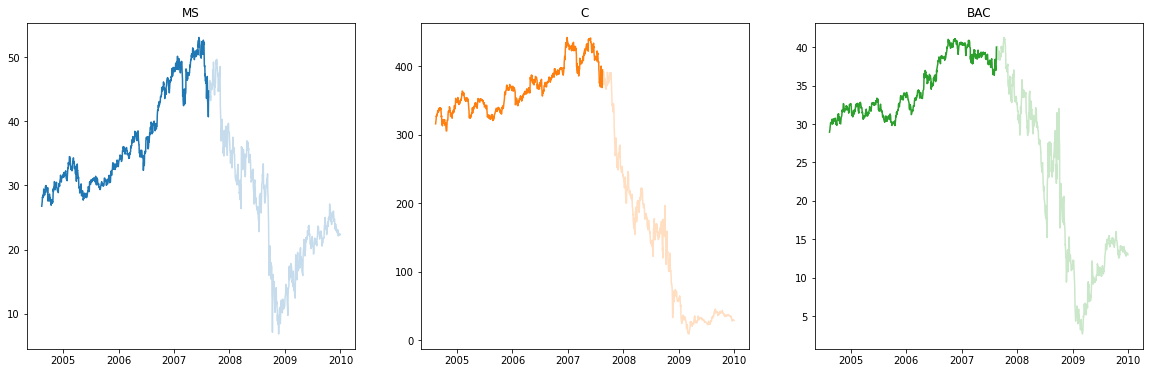

In [19]:
#@title
#Data collection
data_and_tickers = casedata_collect("4") 

tickers = data_and_tickers[0]
all_dfs = data_and_tickers[1]

try:
    del data
except:
    None

# define the variables we want to use, adjClose is necessary to calculate rewards, remaining variables can be set freely by the user
keep_vars = [
             'adjClose', 'volume', # stock information
             'dcf', # discounted cash flow
             'ratingScore', 'ratingDetailsDCFScore', 'ratingDetailsROEScore', 'ratingDetailsROAScore', 'ratingDetailsDEScore', 'ratingDetailsPEScore', 'ratingDetailsPBScore'#, # analyst ratings
             #'momentum_rsi', 'trend_macd', 'volatility_atr' # technical indicators
            ]


# loop through each data frame per stock rename columns and merge data
for t in tickers:
    df = all_dfs[t][keep_vars]
    df.columns = [col_name + '_' + t for col_name in df.columns]

    try:
        data = data.merge(df, how = 'outer', left_index = True, right_index = True, suffixes = ['', ''])
    except:
        data = df.copy()

# if there are only a few, we may just skip those rows, otherwise get other data
data = data[data.isnull().sum(axis = 1) == 0]

# we use 56% of the data for training in order to define the pre crisis period as the training period.
training_fraction = 0.56
training_size = int(len(data) * training_fraction)
# split the data
data_train = data.iloc[:training_size, :]
data_test = data.iloc[training_size:, :]

# let us take a look of the stock price development over the whole time span
cols = sns.color_palette(n_colors = len(tickers))
fig, axs = plt.subplots(1, len(tickers), figsize = (20, 6))

try:
    for i, t in enumerate(tickers):
        axs[i].plot(data_train['adjClose_' + t], color = cols[i], label = t)
        axs[i].plot(data_test['adjClose_' + t], color = cols[i], alpha = 0.25)
        axs[i].set_title(t)
except:
    axs.plot(data_train['adjClose_' + t], color = cols[i], label = t)
    axs.plot(data_test['adjClose_' + t], color = cols[i], alpha = 0.25)
    axs.set_title(t)

#define the state variables
state_vars = data.drop(['adjClose_' + t for t in tickers], axis = 1).columns
# some variables do not change over time, we delete them as nothing can be learned from a variable that does not change over time
#state_vars = state_vars[data_train.drop(['adjClose_' + t for t in tickers], axis = 1).std() > 0.01]
# define the environment for training data
env_train = multiStockEnvironment(data_train, tickers, state_vars, 10000, [], True)
# define the environment for test data, using the state memory from training data for scaling
env_test = multiStockEnvironment(data_test, tickers, state_vars, 10000, env_train.state_memory, True)

adam_policy = tf.keras.optimizers.Adam()
adam_value = tf.keras.optimizers.Adam()

agent = A2C(input_dim = len(env_train.state_variables) + len(tickers) + 1, output_dim = len(env_train.action_list), policy_optimizer = adam_policy, value_optimizer = adam_value, action_list = env_train.action_list)

### The benchmark models

In order to see the agents efficiency it´s output is compared to a set of benchmark models.

The 3 benchmark models follow a buy and hold (B&H) strategy in order to directly compare the possible cut loss of the agent.
The implementation can be executed in the following:

In [23]:
#Implementation of the B&H models

B_H_return = []
investment = 10000

for t in tickers:
  gain = (data["adjClose_" + t][-1] - data["adjClose_" + t][0]) / data["adjClose_" + t][0]
  B_H_return.append(gain)

MS_loss  = investment * B_H_return[0]
C_loss   = investment * B_H_return[1]
BAC_loss = investment * B_H_return[2]

total_loss_abs = MS_loss + C_loss + BAC_loss
total_loss_rel = total_loss_abs  / investment

print(f"The loss in the Morgan Stanley investment yields {round(MS_loss)}, for Citi {round(C_loss)} and for Bank of America {round(BAC_loss)} which leads to a total loss of {round(total_loss_abs)} which is a loss of {round(total_loss_rel*100)}% of the initial investment, assumed that 10000 monetary units are invested in each stock.")


The loss in the Morgan Stanley investment yields -1630, for Citi -9089 and for Bank of America -5507 which leads to a total loss of -16226 which is a loss of -162% of the initial investment, assumed that 10000 monetary units are invested in each stock.


### Test and Training run of the agent

In [ ]:
#@title

#Training ###

from tqdm import tqdm

# the number of training episodes
training_episodes = 5

# collect final values at the end of each episode
final_values = []
# collect time series of portfolio values over time
values_ts = []
# collect time series of actions during each episode
actions_ts = []
# collect information, i.e., the number of stocks and cash over time for each episode
infos_ts = []
# training loss
loss_during_training = []
# collect the learned parameters of the networks after each training episode
agent_weights_policy = []
agent_weights_value = []

# repeat this for the number of training episodes
for _ in tqdm(range(training_episodes)):
    # reset the environment to time step 0
    s = env_train.reset()
    done = False
    # temporary lists to collect actions chosen, values and stock information
    actions = []
    values = []
    infos = []

    # for each episode do the following
    while not(done):
        # choose an action according to epsilon-greedy-strategy
        a = agent.action(s)
        # remember the chosen action
        actions.append(a)
        # take the action, collect the reward and move to the next point in time
        s_, r, done, info = env_train.step(a)
        # memorize the number of stocks at this point in time and the cash position
        infos.append(info)
        # train the agent/update the parameters
        agent.train(s, a, r, s_, done)
        # remember the current value of stocks hold and the cash position
        values.append(env_train._get_value())
        s = s_

    # memorize everything that happened during the episode
    final_values.append(values[-1])
    actions_ts.append(actions)
    values_ts.append(values)
    infos_ts.append(infos)
    agent_weights_policy.append(agent.policy_network.get_weights())
    agent_weights_value.append(agent.value_network.get_weights())

#Testing ###

# after training, we may not want to have any random actions
agent.epsilon = 0

# set the weights 
agent.policy_network.set_weights(agent_weights_policy[np.argmax(final_values)])
agent.value_network.set_weights(agent_weights_value[np.argmax(final_values)])

# play an episode with the trained agent and evaluate its performance under a pure greedy strategy for training and test data
final_values_train = []
values_ts_train = []

s = env_train.reset()
done = False
values = []
infos_train = []

while not(done):
    a = agent.action(s)
    s_, r, done, info = env_train.step(a)
    values.append(env_train._get_value())
    infos_train.append(info)
    s = s_

final_values_train.append(values[-1])
values_ts_train.append(values)

final_values_test = []
values_ts_test = []

s = env_test.reset()
done = False
values = []
infos_test = []

while not(done):
    a = agent.action(s)
    s_, r, done, info = env_test.step(a)
    values.append(env_test._get_value())
    infos_test.append(info)
    s = s_

final_values_test.append(values[-1])
values_ts_test.append(values)


# play an episode with a random agent and evaluate its performance under a pure greedy strategy for training and test data
final_values_train_rnd = []
values_ts_train_rnd = []

s = env_train.reset()
done = False
values_rnd = []
infos_train_rnd = []

while not(done):
    a = random.choice(np.arange(len(env_train.action_list)))
    s_, r, done, info = env_train.step(a)
    values_rnd.append(env_train._get_value())
    infos_train_rnd.append(info)
    s = s_

final_values_train_rnd.append(values_rnd[-1])
values_ts_train_rnd.append(values_rnd)

final_values_test_rnd = []
values_ts_test_rnd = []

s = env_test.reset()
done = False
values_rnd = []
infos_test_rnd = []

while not(done):
    a = random.choice(np.arange(len(env_train.action_list)))
    s_, r, done, info = env_test.step(a)
    values_rnd.append(env_test._get_value())
    infos_test_rnd.append(info)
    s = s_

final_values_test_rnd.append(values_rnd[-1])
values_ts_test_rnd.append(values_rnd)


# fig, axes = plt.subplots(2, 2, figsize = (12, 12))

# axes[0, 0].plot(data_train.index[1:], values_ts_train[0])
# axes[0, 0].set_ylabel('Value training')


# axes[0, 1].plot(data_test.index[1:], values_ts_test[0])
# axes[0, 1].set_ylabel('Value testing')

# for n, t in enumerate(tickers):
#         axes[1, 0].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_train])[:, n], label = t)
# axes[1, 0].legend()
# axes[1, 0].set_ylabel('Stocks in possession')

# for n, t in enumerate(tickers):
#         axes[1, 1].plot(data_test.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_test])[:, n], label = t)
# axes[1, 1].legend()
# axes[1, 1].set_ylabel('Stocks in possession')


# #plot_name = 'multiStockTrading_'
# #plot_name = plot_name + '-'.join(env_train.state_variables) + '.png'
# #plt.savefig(plot_name)
# fig.autofmt_xdate(rotation = 45)
# plt.show()


# fig, axes = plt.subplots(2, 2, figsize = (12, 12))

# axes[0, 0].plot(data_train.index[1:], values_ts_train_rnd[0])
# axes[0, 0].set_ylabel('Value training - random')


# axes[0, 1].plot(data_test.index[1:], values_ts_test_rnd[0])
# axes[0, 1].set_ylabel('Value testing - random')

# for n, t in enumerate(tickers):
#         axes[1, 0].plot(data_train.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_train_rnd])[:, n], label = t)
# axes[1, 0].legend()
# axes[1, 0].set_ylabel('Stocks in possession - random')

# for n, t in enumerate(tickers):
#         axes[1, 1].plot(data_test.index[1:], np.array([info_stock['stocks_in_possession'] for info_stock in infos_test_rnd])[:, n], label = t)
# axes[1, 1].legend()
# axes[1, 1].set_ylabel('Stocks in possession - random')


# #plot_name = 'multiStockTrading_'
# #plot_name = plot_name + '-'.join(env_train.state_variables) + '.png'
# #plt.savefig(plot_name)
# fig.autofmt_xdate(rotation = 45)

In [ ]:
agent_return_rel = (values_ts_test[0][-1] - values_ts_train[0][0]) / values_ts_train[0][0]
agent_return_abs = agent_return_rel * investment

loss_difference = total_loss_rel - agent_return_rel

if loss_difference < 0:
  answer = "not able"
else:
  answer = "able"

print(f"The loss yield by the agent is {round(agent_return_rel*100)}% which is an absolute loss of {round(agent_return_abs)}.  Therefore the agent was {answer} to cut losses of {round(loss_difference)} less as the B&H strategy in the financial crisis.")

The results show that the agent struggles to cut losses in a efficient way. However in some cases the agent is able to nearly hold the initial investment of 10000 monetary units. Therefore the interpretation of the experiments results lies within the right variable and neural network adjustment. As shown in the base cases, an adjusted neural network can highly increase the agents performance.

Of course, the fact that returns of financial firms within a financial crisis are analysed it is not surprising that a different strategy as just to hold the stock is more profitable.

Nevertheless, due to the sensitivity of the results, no general answer can be given even when switching to the Deep Q algorithm. Only the statement that an additional layer and additional neurons, similar to case 3.1, contribute to the loss cut could be obtained from the analysis of the results.

### Conclusion of Section III

The above analysed Base and Special Cases show that a well thought-out algorithm can contribute to the increase in value of a Portfolio. However the implemented algorithms are quiet volatilie regarding the ouptut. Additional layers in the neural network could partially solve the problem as seen in the last Base case or the second Special case. 

Nevertheless the right variable setting, neural network adjustment and epsilon/epsilon decay values have to be set by the user. Therefore the sole algorithm does not always yield the best results. 
Even though every issue which emerged during the empirical investigation, in the sense of a weak performance, could be partially solved by increasing variables and improving the neural network. However, this leads to overfitting and shows the sensitiviy of the algorithm against it´s input.
The literature and community suggest data driven decision making in order to set the right variables and values for the parameters, such as CV. 

However summarizing the positive results, it can be said that reinoforcement learning is a benefit for stock trading and portfolio optimization. Further the Deep Q algorithm may should only be used for short term speculations while the A2C agent is probably the more practical method, since it builds a broughter portfolio without the curse finding the right values, e. g.  for epsilon (decay), and still is able to contribute to the overall portfolio wealth development. Together with an appropriate neural network and trend capturing variables the A2C algorithm performed best in all cases.  

However, even if the cases show promising results, price prediction is still not 100% possible since they can be seen as random. The problem is simply that the algorithm gets trained with historical data and is then expected to make decisions for the future based on that. 

Of course in order to solve that several adjustments and variables can be included but the risk of falling into the Rube Goldberg syndrome then also increases, as some critics say [4]. So a very good algorithm should probably also include the underlying business, its capital structure, macro-economic fundamentals and also human emotions and intentions. The price is only the derivative of these elements. [4]

Nevertheless reinforcement learning in trading contexts is a sufficient gain for the financial market industry and can be used to solve several strategic problems within it.

### External Sources

[1] https://arxiv.org/pdf/1602.01783.pdf

[2] https://www.marketwatch.com/story/here-are-the-most-and-least-volatile-stocks-among-the-sp-500-2019-01-29

[3] https://www.spglobal.com/spdji/en/indices/indicators/sp-500-12-month-realized-volatility-index/#overview

Data was obtained by https://financialmodelingprep.com/

[4] https://hackernoon.com/https-medium-com-supernova-the-truth-nobody-wants-to-tell-you-about-ai-for-trading-5d29a297ee93
